In [5]:
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error
import networkx as nx

In [6]:
def plotFMI(G, save_path=None):
    # Define colors for clusters
    colors = np.array(['black', 'green', 'red', 'brown', 'deeppink',
                       'blue', 'olive', 'gray', 'orange', 'purple'])

    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])
    clusters = np.array([G.nodes[node]['cluster'] for node in G.nodes])

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(coords[:, 1], coords[:, 0], c=colors[clusters], s=50, zorder=5)

    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color=colors[clusters[node]], fontweight='bold')

    for u, v in G.edges:
        u_color = colors[G.nodes[u]['cluster']]
        v_color = colors[G.nodes[v]['cluster']]
        u_coords = G.nodes[u]['coord']
        v_coords = G.nodes[v]['coord']

        mid_point = [(u_coords[0] + v_coords[0]) / 2, (u_coords[1] + v_coords[1]) / 2]
        ax.plot([u_coords[1], mid_point[1]], [u_coords[0], mid_point[0]], linestyle='-', color=u_color, zorder=3)
        ax.plot([mid_point[1], v_coords[1]], [mid_point[0], v_coords[0]], linestyle='-', color=v_color, zorder=3)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations Colored by Cluster')
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except: 
            print("Failed to save the plot. Invalid file path.")
            
    plt.show()

def add_edges(G, z='coord', numneighbors=4):
    graph_with_edges = copy.deepcopy(G)

    # Extract the representation vector
    if z == 'Timestamp':
        representation_vector = np.array([graph_with_edges.nodes[node][z].timestamp() for node in graph_with_edges.nodes]).reshape(-1, 1)
    else:
        representation_vector = np.array([graph_with_edges.nodes[node][z] for node in graph_with_edges.nodes])

    adjacency_matrix = kneighbors_graph(representation_vector, 
                                        numneighbors, 
                                        mode='connectivity', 
                                        include_self=False)

    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

def ExtractFeatureMatrixLabelVector(data):
    temps = data['temp'].values
    latitudes = data['Latitude'].values / 100
    longitudes = data['Longitude'].values / 100

    timestamps = pd.to_datetime(data['Timestamp'])
    year = timestamps.dt.year / 2025
    month = timestamps.dt.month / 13
    day = timestamps.dt.day / 32
    hour = timestamps.dt.hour / 25
    minute = timestamps.dt.minute / 61

    X = np.column_stack([latitudes, longitudes, year, month, day, hour, minute])
    y = temps.reshape(-1, 1)

    return X, y

In [7]:
data = pd.read_csv('fmi_data.csv')

# Equally-sized local dataset is needed for vertical FL
# Identify stations with fewer than 96 entries
stations_to_remove = data.groupby('name').filter(lambda x: len(x) < 96)['name'].unique()

data = data[~data['name'].isin(stations_to_remove)]

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

n_stations = len(data.name.unique())
n_datapoints = len(data)

The empirical graph is connected: True


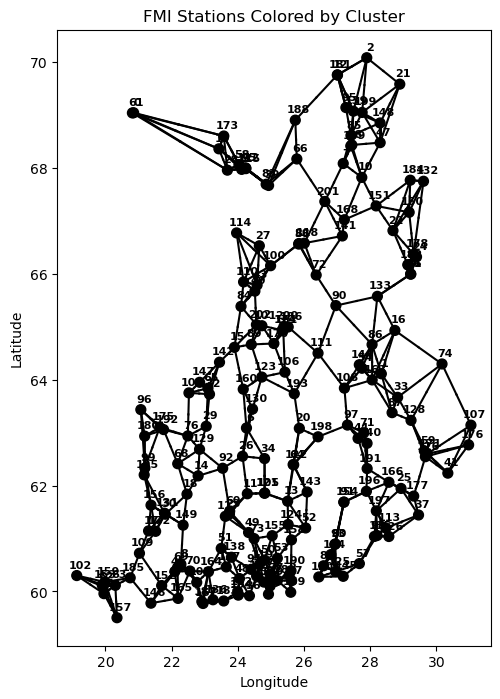

In [8]:
G_FMI_no_edges = nx.Graph()

# Add one node per station
G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.name.unique()):
    station_data = data[data.name==station]

    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)

    G_FMI_no_edges.nodes[i].update({
        'samplesize': len(y_node),
        'name': station,
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]),
        'X': X_node,
        'y': y_node,
        'cluster': 0
    })

G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

plotFMI(G_FMI)

### Task 1: Vertical FL

In [9]:
# Sort data by ascending Timestamp
data = data.sort_values('Timestamp')

# Group the data by 'Timestamp'
X = data.groupby('Timestamp')['temp'].apply(np.array).to_numpy()[:-1]
y = data.groupby('Timestamp')['temp'].mean().to_numpy()[1:]

datapoints = np.array([(X[i], y[i]) for i in range(len(y))], dtype='object')

In [10]:
timestamps = data['Timestamp'].unique()

G_FMI_vertical = nx.Graph()

G_FMI_vertical.add_nodes_from(range(0, len(datapoints)))

for node in G_FMI_vertical.nodes:
    G_FMI_vertical.nodes[node].update({
        'Timestamp': timestamps[node],
        'X': datapoints[node][0],
        'y': datapoints[node][1],
    })

G_FMI_vertical = add_edges(G_FMI_vertical, z='Timestamp', numneighbors=4)

gtvmin_alpha = 0.9

In [11]:
from scipy.sparse import block_diag
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

Q_list = []
q_list = []

for i in range(len(datapoints)):
    X_i = datapoints[i][0].reshape(1, -1)
    y_i = datapoints[i][1].reshape(-1, 1)
    m_i = len(X_i)

    Q_i = (1 / m_i) * np.dot(X_i.T, X_i)
    Q_list.append(Q_i)
    
    q_i = (-2 / m_i) * np.dot(X_i.T, y_i)
    q_list.append(q_i)

Q_blockdiag = block_diag(Q_list).tocsc()
q_stacked = np.vstack(q_list)        # shape: (n*d, 1)
print('Q_blockdiag shape:', Q_blockdiag.shape, '\nq_stacked shape:  ', q_stacked.shape)

d = len(X[0])
L_FMI = nx.laplacian_matrix(G_FMI_vertical).toarray()  # shape: (n, n)
I_d = np.eye(d) # shape: d x d
L_kron = csr_matrix(np.kron(L_FMI, I_d))
print('L_kron shape', L_kron.shape)

Q = Q_blockdiag + gtvmin_alpha * L_kron
print('Q shape:', Q.shape)

q = q_stacked.reshape(-1, 1)
print('q shape:', q.shape)

hat_w = spsolve(Q, -0.5*q)
hat_w = hat_w.reshape(-1, d)
print('hat_w', hat_w.shape)


X_toy = np.ones((5, 3))
y_toy = np.ones((5, 1))*2
datapoints_toy = np.array([(X_toy[i], y_toy[i]) for i in range(len(y_toy))], dtype='object')

Q_blockdiag shape: (19285, 19285) 
q_stacked shape:   (19285, 1)
L_kron shape (19285, 19285)
Q shape: (19285, 19285)
q shape: (19285, 1)
hat_w (95, 203)


### Task 2: Clustered FL

### Task 2.1 K-Means with coordinates as a representation vector

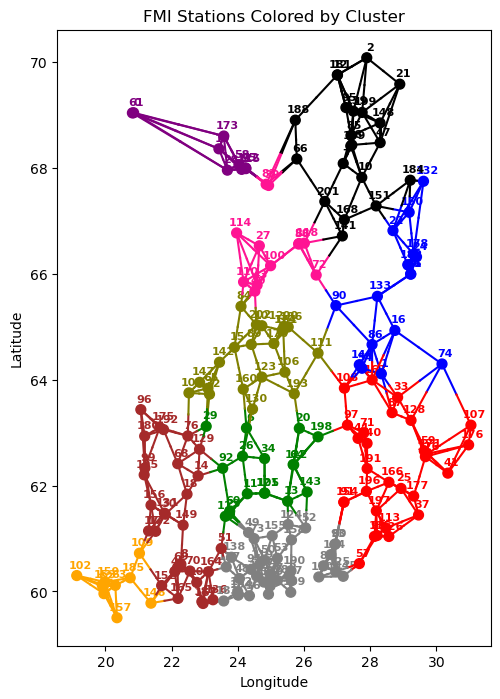

Cluster 0: [2, 7, 10, 12, 21, 38, 47, 66, 85, 95, 139, 141, 148, 151, 168, 181, 184, 188, 189, 199, 201]
Cluster 1: [6, 11, 13, 20, 23, 26, 29, 34, 60, 64, 92, 105, 117, 121, 122, 143, 198]
Cluster 2: [25, 33, 37, 41, 44, 57, 59, 71, 87, 91, 97, 98, 107, 108, 113, 116, 126, 128, 135, 140, 154, 163, 166, 171, 176, 177, 191, 196, 197]
Cluster 3: [8, 14, 17, 18, 30, 45, 51, 68, 69, 70, 76, 96, 99, 103, 129, 131, 136, 149, 152, 156, 164, 165, 167, 172, 175, 180, 187, 192, 195]
Cluster 4: [27, 39, 40, 43, 56, 72, 83, 88, 100, 110, 114, 118]
Cluster 5: [1, 4, 16, 22, 24, 31, 46, 54, 74, 86, 90, 132, 133, 144, 150, 178, 182]
Cluster 6: [15, 32, 65, 84, 89, 101, 104, 106, 111, 123, 130, 142, 147, 160, 161, 170, 174, 186, 193, 200, 202]
Cluster 7: [5, 35, 36, 42, 48, 49, 50, 52, 53, 55, 67, 73, 77, 78, 79, 80, 81, 82, 93, 94, 119, 120, 124, 125, 127, 134, 137, 138, 145, 155, 158, 162, 169, 179, 183, 190, 194]
Cluster 8: [3, 62, 63, 102, 109, 146, 153, 157, 159, 185]
Cluster 9: [0, 9, 19, 28, 58

In [12]:
k = 10
seed = 4740

avg_error = 0

coordinates = np.array([G_FMI.nodes[i_node]['coord'] for i_node in G_FMI.nodes])

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(coordinates)

for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

avg_temperatures = np.zeros(k)

for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints

plotFMI(G_FMI)

for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

print(f"\nThe average squared loss over all data points is {avg_error}")

In [13]:
test_avg_error = 0

coordinates = np.array([G_FMI.nodes[i_node]['coord'] for i_node in G_FMI.nodes])

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(coordinates)

for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

avg_temperatures = np.zeros(k)

for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)

#### K-Means with GMM parameters as a representation vector

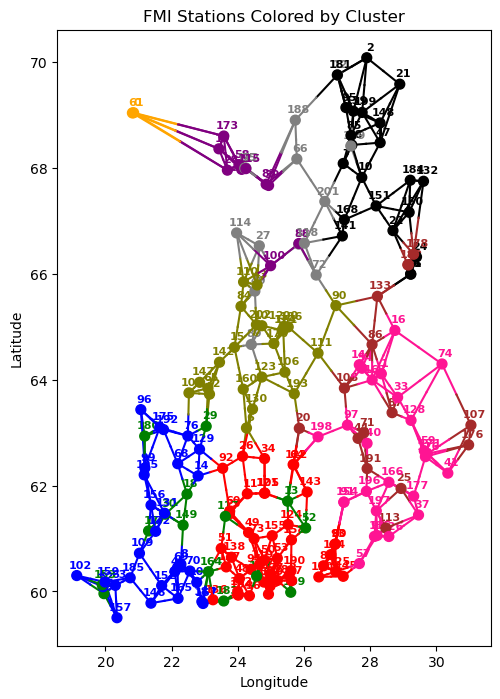

Cluster 0: [2, 7, 10, 21, 22, 24, 31, 38, 46, 47, 85, 95, 132, 139, 141, 148, 150, 151, 168, 181, 184, 199]
Cluster 1: [3, 13, 17, 18, 29, 30, 52, 117, 137, 149, 153, 164, 169, 180, 183]
Cluster 2: [5, 11, 23, 26, 34, 35, 36, 42, 48, 49, 50, 51, 53, 55, 60, 64, 67, 73, 77, 78, 79, 80, 81, 82, 92, 93, 94, 105, 119, 120, 121, 122, 124, 125, 127, 134, 136, 138, 143, 145, 155, 158, 162, 179, 190, 194]
Cluster 3: [4, 20, 25, 44, 71, 86, 87, 107, 108, 113, 133, 176, 178, 182, 191]
Cluster 4: [1, 16, 33, 37, 41, 54, 57, 59, 74, 91, 97, 98, 116, 126, 128, 135, 140, 144, 154, 163, 166, 171, 177, 196, 197, 198]
Cluster 5: [8, 14, 45, 62, 63, 68, 69, 70, 76, 96, 99, 102, 103, 109, 129, 131, 146, 152, 156, 157, 159, 165, 167, 172, 175, 185, 187, 192, 195]
Cluster 6: [6, 15, 32, 43, 65, 84, 90, 101, 104, 106, 110, 111, 123, 130, 142, 147, 160, 161, 170, 174, 186, 193, 200, 202]
Cluster 7: [12, 27, 40, 56, 66, 72, 75, 89, 112, 114, 118, 188, 189, 201]
Cluster 8: [0, 61]
Cluster 9: [9, 19, 28, 39, 58

In [14]:
n_components = 2

avg_error = 0

for node in G_FMI.nodes():

    node_X = G_FMI.nodes[node]['X']

    gmm = GaussianMixture(n_components=n_components, random_state = seed) 
    gmm.fit(node_X)

    gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))

    G_FMI.nodes[node]['gmm_params'] = gmm_params

gmm_params = np.array([G_FMI.nodes[i_node]['gmm_params'] for i_node in G_FMI.nodes])

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(gmm_params)

for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

avg_temperatures = np.zeros(k)
for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints

plotFMI(G_FMI)

for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

print(f"\nThe average squared loss over all datapoints is {avg_error}")

In [15]:
test_avg_error = 0

for node in G_FMI.nodes():
    
    node_X = G_FMI.nodes[node]['X']
    
    gmm = GaussianMixture(n_components=n_components, random_state = seed) 
    gmm.fit(node_X)
    
    gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))
    
    G_FMI.nodes[node]['gmm_params'] = gmm_params

gmm_params = np.array([G_FMI.nodes[i_node]['gmm_params'] for i_node in G_FMI.nodes])

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(gmm_params)

for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
avg_temperatures = np.zeros(k)
for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)

#### K-Means with eigenvectors of the Laplacian matrix as a representation vector

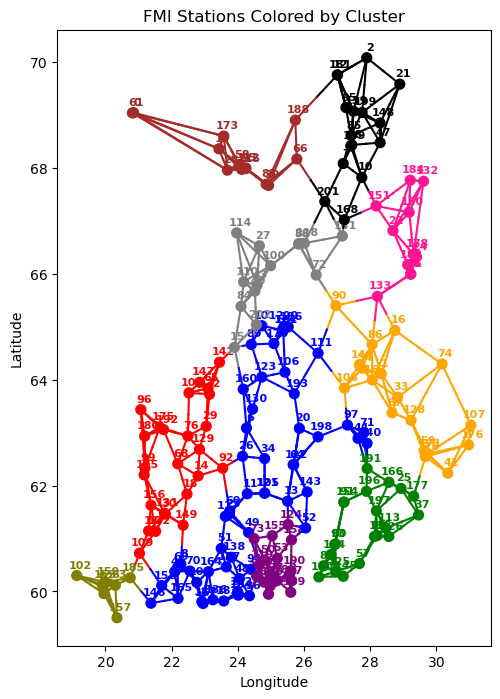

Cluster 0: [2, 7, 10, 12, 21, 38, 47, 85, 95, 139, 148, 168, 181, 189, 199, 201]
Cluster 1: [25, 37, 57, 80, 81, 91, 93, 98, 113, 120, 125, 126, 135, 145, 154, 166, 177, 191, 194, 196, 197]
Cluster 2: [14, 17, 18, 29, 30, 32, 65, 68, 76, 92, 96, 99, 104, 109, 129, 131, 142, 147, 149, 156, 172, 175, 180, 192, 195]
Cluster 3: [0, 9, 19, 28, 39, 58, 61, 66, 75, 83, 112, 115, 173, 188]
Cluster 4: [4, 22, 24, 31, 46, 132, 133, 150, 151, 178, 182, 184]
Cluster 5: [6, 8, 11, 13, 20, 23, 26, 34, 36, 44, 45, 48, 49, 51, 52, 60, 64, 69, 70, 71, 89, 94, 97, 101, 103, 105, 106, 111, 117, 121, 122, 123, 127, 130, 134, 136, 138, 140, 143, 146, 152, 160, 161, 162, 164, 165, 167, 170, 174, 183, 186, 187, 193, 198, 200]
Cluster 6: [3, 62, 63, 102, 153, 157, 159, 185]
Cluster 7: [15, 27, 40, 43, 56, 72, 84, 88, 100, 110, 114, 118, 141, 202]
Cluster 8: [1, 16, 33, 41, 54, 59, 74, 86, 87, 90, 107, 108, 116, 128, 144, 163, 171, 176]
Cluster 9: [5, 35, 42, 50, 53, 55, 67, 73, 77, 78, 79, 82, 119, 124, 137, 

In [16]:
avg_error = 0

L = nx.laplacian_matrix(G_FMI).toarray()

eigenvalues, eigenvectors = LA.eig(L)

idx_sorted = np.argsort(eigenvalues)

eigenvalues_sorted = eigenvalues[idx_sorted]

eigenvectors_sorted = eigenvectors.T[idx_sorted]

k_eigen = eigenvectors_sorted[1:k+1].T

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(k_eigen)


for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
avg_temperatures = np.zeros(k)
for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints

plotFMI(G_FMI, save_path='clustered_FMI_graph.png')

for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

print(f"\nThe average squared loss over all datapoints is {avg_error}")

In [17]:
test_avg_error = 0
test_avg_error_without_first = 0

L = nx.laplacian_matrix(G_FMI).toarray()

eigenvalues, eigenvectors = LA.eig(L)

idx_sorted = np.argsort(eigenvalues)

eigenvalues_sorted = eigenvalues[idx_sorted]
eigenvectors_sorted = eigenvectors.T[idx_sorted]

k_eigen = eigenvectors_sorted[1:k+1].T

kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(k_eigen)

for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
avg_temperatures = np.zeros(k)
for cluster in range(k):
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)